In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import auc, roc_curve,roc_auc_score
from sklearn.linear_model import LinearRegression
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except:
    !pip install matplotlib
    !pip install nbformat
    !pip install seaborn
    import matplotlib.pyplot as plt
    import seaborn as sns



In [3]:
dataset = "Waterbirds"  # Waterbirds, CelebA
class_name = "waterbird" # waterbird, landbird, blond, not blond 
do_all_kw = False # if want to closer resemble paper, set to False

In [4]:
diff_path = "b2t/diff/output_"+dataset+"_erm_"+ class_name+".csv"

dataset__ = "waterbird" if dataset == "Waterbirds" else "celeba"
if not os.path.exists(diff_path):
    # Define the Pipenv command and script
    command = f"cd b2t && python b2t.py --dataset {dataset__} --model best_model_{dataset}_erm.pth --save_result"
    
    # Run the command using the Pipenv environment
    !pipenv run bash -c "{command}"

cols = ['Keyword', 'Score', 'Acc.', 'Bias']
df_waterbird = pd.read_csv(diff_path)
df_waterbird = df_waterbird[cols]
dfs = [df_waterbird]
keywords = df_waterbird["Keyword"].values

if class_name == "waterbird":
    keywords_limited = ["bamboo","forest", "woods", "species", "bird"]  # keywords in fig of paper
elif class_name == "landbird":
    keywords_limited = ["beach","water", "lake", "species", "bird"]  # keywords in fig of paper
else:
    print("class_name not recognized")

if do_all_kw:
    keywords_limited = keywords
    


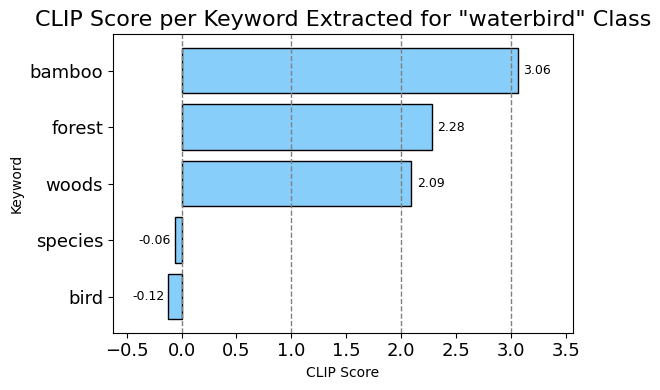

In [16]:
df = dfs[0]

df = df.iloc[::-1] # reverse for correct order

# Extract keywords from in the p
df = df[df["Keyword"].isin(keywords_limited)]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot horizontal bars
ax.barh(df['Keyword'], df['Score'], color='lightskyblue', edgecolor='black')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

# Add labels on the bars
for i, (score, keyword) in enumerate(zip(df['Score'], df['Keyword'])): # allow for correct location of negative score
    alligner = 0
    if score < -0:
        if score < -0.25:
            alligner = -0.35
        else:
            alligner = -0.35 +  ( - score/4)
    else:
        alligner = 0.05
    ax.text(score+alligner, i, f"{score:.2f}", va='center', fontsize=9)

# Add titles and labels
ax.set_title('CLIP Score per Keyword Extracted for "' + class_name  +'" Class', fontsize=16)
ax.set_xlabel('CLIP Score')
ax.set_ylabel('Keyword')

# Adjust x-axis limit
max_score = df['Score'].max()
max_score = max_score + np.sign(max_score)*0.5
min_score = df['Score'].min()
min_score = min_score + np.sign(min_score)*0.5
ax.set_xlim(left=min_score, right=max_score)

for idx in range(int(np.floor(min_score)),int(np.ceil(max_score))):
    ax.axvline(idx, color='gray', linestyle='--', linewidth=1)


# Adjust layout
plt.tight_layout()
plt.savefig("b2t/plots/CLIP_SCORES.png", dpi=200, bbox_inches='tight')

plt.show()

In [19]:
# loads simiarities for every image to every keyword in waterbird class set
similarities_folder ="CLIP_similarities/"
similarities_csv_path = similarities_folder+ "similarities_df_"+class_name+".csv"

if not os.path.exists("b2t/"+similarities_csv_path):
    # file or directory exists
    image_dir = "data/cub/data/waterbird_complete95_forest2water2/" if dataset == "Waterbirds" else "b2t/data/celeba/data/"
    waterbird_csv = diff_path[len("b2t/"):]
    dataset__ = "waterbird" if dataset == "Waterbirds" else "celeba"
    result_csv = "result/"+dataset__+"_best_model_"+dataset+"_erm.csv"


    # Format the command string using the variables
    command = f""" cd b2t && python {similarities_folder}similarity_per_image.py \
        --image_dir {image_dir} \
        --waterbird_csv {waterbird_csv} \
        --save_csv {similarities_csv_path} \
        --result_csv {result_csv}
    """

    # Execute the command in Colab
    !pipenv run bash -c "{command}"

df_similarities = pd.read_csv("b2t/"+similarities_csv_path)
df_similarities = df_similarities[keywords]


In [20]:
# loads ERM model predictions for every image to every keyword in waterbird class set
# should exist already from first pipenv run in this file
result_csv = "result/"+dataset__+"_best_model_"+dataset+"_erm.csv"
df_results = pd.read_csv("b2t/"+result_csv)

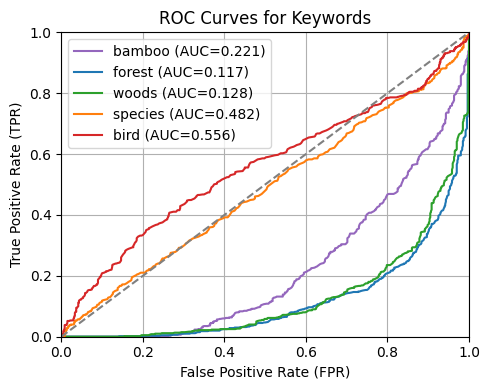

In [21]:
colors = [ "#9467bd","#1f77b4","#2ca02c", "#ff7f0e","#d62728",]

fpr_tpr_dict = {}

# Calculate ROC curve for each keyword
for kw in keywords_limited:
    y_scores = df_similarities[kw].values  # Similarity scores for the keyword

    y_true = df_results["spurious"].values  

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    
    fpr_tpr_dict[kw] = (fpr, tpr)


# Plot ROC curves
plt.figure(figsize=(5, 4))

for i,(kw, (fpr, tpr)) in enumerate(fpr_tpr_dict.items()):
    if do_all_kw:
        plt.plot(fpr, tpr, label=kw + f' (AUC={auc(fpr,tpr):.3f})')
    else:
        plt.plot(fpr, tpr, label=kw + f' (AUC={auc(fpr,tpr):.3f})', color=colors[i])


plt.plot([0,1], [0,1], '--', color="gray")  # Diagonal line for reference
plt.title('ROC Curves for Keywords')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(title='Keywords', loc="lower right")
plt.xlim(left=0,right=1)  
plt.ylim(bottom=0,top=1)  
# legend left upper corner
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("b2t/plots/ROC_KEYWORDS.png", dpi=800, bbox_inches='tight')
plt.show()
# this version thresholds, if exceeds threshold it is predicted as positive, then checks if for these points the label is positive or not.


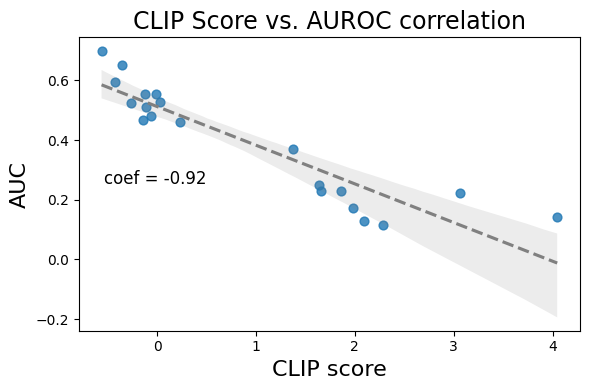

In [27]:
df = dfs[0]
# Fit a linear regression model
auroc_values = []
clip_scores = []
for kw in keywords:
    clip_scores.append(df["Score"][df["Keyword"] == kw])
    auroc = roc_auc_score(y_true, df_similarities[kw].values)
    auroc_values.append(auroc)

clip_scores = np.array(clip_scores)
clip_scores = clip_scores.reshape(-1, 1)  # Reshape for sklearn
model = LinearRegression()
model.fit(clip_scores, auroc_values)
predicted_auroc = model.predict(clip_scores)

# Extract the coefficient using normalised data
clip_scores_norm = (clip_scores - np.mean(clip_scores)) / np.std(clip_scores)
auroc_values_norm = (auroc_values - np.mean(auroc_values)) / np.std(auroc_values)
model_norm = LinearRegression()
model_norm.fit(clip_scores_norm, auroc_values_norm)
coef = model_norm.coef_[0]  

# Plot
plt.figure(figsize=(6, 4))
sns.regplot(x=clip_scores.flatten(), y=auroc_values, scatter_kws={'s': 40}, line_kws={'color': 'gray', 'linestyle': '--'})  
plt.text(0.05, 0.5, f"coef = {coef:.2f}", transform=plt.gca().transAxes, fontsize=12)

# Add labels and styling
plt.title("CLIP Score vs. AUROC correlation",fontdict={'fontsize': 17})
plt.xlabel("CLIP score",fontsize=16)
plt.ylabel("AUC",fontsize=16)
plt.grid(False)
plt.tight_layout()
# Show plot
plt.savefig("b2t/plots/AUROC_CORR.png", dpi=200, bbox_inches='tight')
plt.show()

In [56]:
#WIP
# voor debias: idenity niet in file mss codalab download zoals joey deed